<a href="https://colab.research.google.com/github/jocker1854/Deep-Learning-Projects/blob/main/MaskDetectionPyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-mask-detection


In [2]:
ls /kaggle/input/face-mask-detection

annotations/  images/


In [6]:
path = '/kaggle/input/face-mask-detection'

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
import xml.etree.ElementTree as ET
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [8]:
import os
from PIL import Image
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import Dataset

class MaskDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transforms=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms

        self.image_files = []
        for f in os.listdir(self.annotation_dir):
            if f.endswith('.xml'):
                base = os.path.splitext(f)[0]
                if os.path.exists(os.path.join(image_dir, base + ".png")) or \
                   os.path.exists(os.path.join(image_dir, base + ".jpg")):
                    self.image_files.append(base)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]

        # Dynamically get image path
        if os.path.exists(os.path.join(self.image_dir, filename + ".jpg")):
            img_path = os.path.join(self.image_dir, filename + ".jpg")
        elif os.path.exists(os.path.join(self.image_dir, filename + ".png")):
            img_path = os.path.join(self.image_dir, filename + ".png")
        else:
            raise FileNotFoundError(f"No image found for {filename}")

        ann_path = os.path.join(self.annotation_dir, filename + ".xml")

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Load annotation (basic example — customize for bbox & labels)
        tree = ET.parse(ann_path)
        root = tree.getroot()
        boxes = []
        labels = []

        for obj in root.findall("object"):
            label = obj.find("name").text
            bbox = obj.find("bndbox")
            xmin = int(float(bbox.find("xmin").text))
            ymin = int(float(bbox.find("ymin").text))
            xmax = int(float(bbox.find("xmax").text))
            ymax = int(float(bbox.find("ymax").text))
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1 if label == "with_mask" else 2 if label == "without_mask" else 3)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target


In [9]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 3  # background + 2 mask classes

model = get_model(num_classes)

try:
    model.to(device)
    print("Model moved to device successfully!")
except RuntimeError as e:
    print("RuntimeError:", e)



Model moved to device successfully!


In [34]:
# @title
!pip uninstall torch torchvision torchaudio
!pip cache purge
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Would remove:
    /usr/local/bin/torchfrtrace
    /usr/local/bin/torchrun
    /usr/local/lib/python3.11/dist-packages/functorch/*
    /usr/local/lib/python3.11/dist-packages/torch-2.6.0+cu124.dist-info/*
    /usr/local/lib/python3.11/dist-packages/torch/*
    /usr/local/lib/python3.11/dist-packages/torchgen/*
Proceed (Y/n)? y
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/torchvision-0.21.0+cu124.dist-info/*
    /usr/local/lib/python3.11/dist-packages/torchvision.libs/libcudart.41118559.so.12
    /usr/local/lib/python3.11/dist-packages/torchvision.libs/libjpeg.1c1c4b09.so.8
    /usr/local/lib/python3.11/dist-packages/torchvision.libs/libnvjpeg.02b6d700.so.12
    /usr/local/lib/python3.11/dist-packages/torchvision.libs/libpng16.0364a1db.so.16
    /usr/local/l

In [10]:
import torch, torchvision
print(torch.__version__)
print(torchvision.__version__)

2.7.0+cu118
0.22.0+cu118


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
# @title
import os
import xml.etree.ElementTree as ET

def check_mask_dataset(images_dir, annotations_dir):
    images = set(os.listdir(images_dir))
    annotations = set(os.listdir(annotations_dir))

    image_basenames = set(os.path.splitext(img)[0] for img in images if img.endswith(('.jpg', '.png')))
    annotation_basenames = set(os.path.splitext(ann)[0] for ann in annotations if ann.endswith('.xml'))

    missing_annotations = image_basenames - annotation_basenames
    missing_images = annotation_basenames - image_basenames
    empty_labels = []

    for ann in annotation_basenames:
        ann_path = os.path.join(annotations_dir, ann + ".xml")
        try:
            tree = ET.parse(ann_path)
            root = tree.getroot()
            objects = root.findall("object")
            if not objects:
                empty_labels.append(ann + ".xml")
        except ET.ParseError:
            print(f"❌ Could not parse XML: {ann_path}")

    # Summary
    print("=== Mask Dataset Validation ===")
    print(f"Total Images: {len(image_basenames)}")
    print(f"Total Annotations: {len(annotation_basenames)}")
    print(f"❌ Missing Annotations: {missing_annotations}" if missing_annotations else "✅ No missing annotations")
    print(f"❌ Missing Images: {missing_images}" if missing_images else "✅ No missing images")
    print(f"❌ Empty Labels: {empty_labels}" if empty_labels else "✅ All annotations have labels")

# Example usage
check_mask_dataset(f"{path}/images", f"{path}/annotations")


=== Mask Dataset Validation ===
Total Images: 853
Total Annotations: 853
✅ No missing annotations
✅ No missing images
✅ All annotations have labels


In [12]:
f'{path}/images'

'/kaggle/input/face-mask-detection/images'

In [29]:
# @title
import os
import xml.etree.ElementTree as ET

# Paths (adjust if needed)
images_dir = "/kaggle/input/face-mask-detection/images"
annotations_dir = "/kaggle/input/face-mask-detection/annotations"  # make sure this exists

def check_mask_dataset(images_dir, annotations_dir):
    images = set(os.listdir(images_dir))
    annotations = set(os.listdir(annotations_dir))

    image_basenames = set(os.path.splitext(img)[0] for img in images if img.lower().endswith(('.jpg', '.png')))
    annotation_basenames = set(os.path.splitext(ann)[0] for ann in annotations if ann.lower().endswith('.xml'))

    missing_annotations = image_basenames - annotation_basenames
    missing_images = annotation_basenames - image_basenames
    empty_labels = []
    unreadable_xml = []

    for ann in annotation_basenames:
        ann_path = os.path.join(annotations_dir, ann + ".xml")
        try:
            tree = ET.parse(ann_path)
            root = tree.getroot()
            objects = root.findall("object")
            if not objects:
                empty_labels.append(ann + ".xml")
        except ET.ParseError:
            unreadable_xml.append(ann + ".xml")

    # Output
    print("=== Mask Dataset Check ===")
    print(f"Total Images: {len(image_basenames)}")
    print(f"Total Annotations: {len(annotation_basenames)}")

    if missing_annotations:
        print(f"❌ Missing Annotations for Images: {missing_annotations}")
    else:
        print("✅ No missing annotations")

    if missing_images:
        print(f"❌ Missing Images for Annotations: {missing_images}")
    else:
        print("✅ No missing images")

    if empty_labels:
        print(f"❌ Empty Labels in Annotations: {empty_labels}")
    else:
        print("✅ All annotations have labels")

    if unreadable_xml:
        print(f"❌ Unreadable XML files: {unreadable_xml}")
    else:
        print("✅ All XMLs are readable")

# Run the check
check_mask_dataset(images_dir, "/kaggle/input/face-mask-detection/annotations")


=== Mask Dataset Check ===
Total Images: 853
Total Annotations: 853
✅ No missing annotations
✅ No missing images
✅ All annotations have labels
✅ All XMLs are readable


In [ ]:
# @title
img_path = os.path.join(images_dir, filename + ".png")
ann_path = os.path.join(annotations_dir, filename + ".xml")

In [30]:
# @title
import os
from PIL import Image
import xml.etree.ElementTree as ET

def load_example(images_dir, annotations_dir, filename):
    # Try both .jpg and .png
    image_path_jpg = os.path.join(images_dir, filename + ".jpg")
    image_path_png = os.path.join(images_dir, filename + ".png")

    if os.path.exists(image_path_jpg):
        img_path = image_path_jpg
    elif os.path.exists(image_path_png):
        img_path = image_path_png
    else:
        raise FileNotFoundError(f"No image found for {filename} in JPG or PNG format.")

    ann_path = os.path.join(annotations_dir, filename + ".xml")

    if not os.path.exists(ann_path):
        raise FileNotFoundError(f"No annotation found for {filename}.")

    image = Image.open(img_path).convert("RGB")
    tree = ET.parse(ann_path)
    # further processing...

    return image, tree

load_example(images_dir=f'{path}/images', annotations_dir=f'{path}/annotations', filename='maksssksksss354.png')

FileNotFoundError: No image found for maksssksksss354.png in JPG or PNG format.

In [31]:
# @title
import os

ann_dir = "/kaggle/input/face-mask-detection/annotations"
image_dir = "/kaggle/input/face-mask-detection/images"

filename = "maksssksksss354"

# 1. Check annotation file
ann_path = os.path.join(ann_dir, filename + ".xml")
print("Annotation exists:", os.path.exists(ann_path))

# 2. Check image file variants
jpg = os.path.join(image_dir, filename + ".jpg")
png = os.path.join(image_dir, filename + ".png")
print("JPG exists:", os.path.exists(jpg))
print("PNG exists:", os.path.exists(png))


Annotation exists: True
JPG exists: False
PNG exists: True


In [13]:
# Prepare dataset
dataset = MaskDataset(
    image_dir=f'{path}/images',
    annotation_dir=f'{path}/annotations',
    transforms=ToTensor()
)

In [14]:
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [15]:
# @title
# Model
num_classes = 3  # 0=background, 1=with_mask, 2=without_mask
model = get_model(num_classes)


In [16]:
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
11.8
0
Tesla T4


In [17]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [18]:
# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [19]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [20]:
# Training
model.train()
for epoch in range(10):
    for imgs, targets in data_loader:
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {losses.item():.4f}")

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
path

'/kaggle/input/face-mask-detection'

In [ ]:
torch.save(model.state_dict(), "mask_detector_fasterrcnn.pth")

### old

In [ ]:
# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Load dataset
train_data = datasets.ImageFolder(root='mask_dataset/train', transform=transform)
val_data = datasets.ImageFolder(root='mask_dataset/val', transform=transform)

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [ ]:
# Load pretrained ResNet18 model
model = models.resnet18(pretrained=True)

In [ ]:
# Modify the final layer for 2 classes (mask, no mask)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

In [ ]:
for targets in dataloader:
    for t in targets:
        labels = t['labels']
        if (labels < 0).any() or (labels >= num_classes).any():
            print(f"Invalid labels found: {labels}")


In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

In [ ]:
# Save the model
torch.save(model.state_dict(), 'mask_detector.pth')

### New

In [22]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image

# =============== Dataset ===============
class MaskDataset(Dataset):
    def __init__(self, img_dir, annotations, transforms=None, num_classes=3):
        """
        img_dir: folder with images
        annotations: dict {image_id: {'boxes': [[xmin,ymin,xmax,ymax],...], 'labels':[...]} }
        num_classes: total classes including background
        """
        self.img_dir = img_dir
        self.annotations = annotations
        self.ids = list(annotations.keys())
        self.transforms = transforms
        self.num_classes = num_classes

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_path = os.path.join(self.img_dir, img_id)
        img = Image.open(img_path).convert("RGB")

        ann = self.annotations[img_id]

        boxes = torch.tensor(ann['boxes'], dtype=torch.float32)
        labels = torch.tensor(ann['labels'], dtype=torch.int64)

        # --- LABEL FIX: shift labels by +1 if they start from 0 ---
        # Because Faster R-CNN expects background=0, classes >=1
        labels = labels + 1
        assert (labels >= 1).all() and (labels < self.num_classes).all(), \
            f"Labels must be in [1, {self.num_classes-1}], got {labels}"

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        if self.transforms:
            img = self.transforms(img)

        return img, target

# =============== Model Setup ===============
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace head with new predictor for our classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# =============== Example usage ===============
def collate_fn(batch):
    return tuple(zip(*batch))

def main():
    device = torch.device('cpu')

    # Dummy annotations example — replace with your actual data loading logic
    annotations = {
        "image1.jpg": {
            "boxes": [[10, 20, 100, 200], [50, 60, 150, 160]],
            "labels": [0, 1]  # 0=with_mask, 1=without_mask in your dataset, will shift +1 below
        },
        "image2.jpg": {
            "boxes": [[30, 40, 120, 220]],
            "labels": [0]
        },
        # Add more...
    }
    img_dir = "/kaggle/input/face-mask-detection/images"  # Update your image folder path

    num_classes = 3  # background + 2 classes: with_mask, without_mask

    dataset = MaskDataset(img_dir, annotations, transforms=None, num_classes=num_classes)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

    model = get_model(num_classes)
    model.to(device)

    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

    for epoch in range(2):  # 2 epochs example
        for imgs, targets in dataloader:
            imgs = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # DEBUG: label range check before forward pass
            for t in targets:
                labels = t['labels']
                if (labels < 0).any() or (labels >= num_classes).any():
                    raise ValueError(f"Invalid labels: {labels}")

            loss_dict = model(imgs, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            print(f"Epoch {epoch} Loss: {losses.item():.4f}")

if __name__ == "__main__":
    main()


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/face-mask-detection/images/image2.jpg'

In [23]:
for i in range(len(dataset)):
    _, target = dataset[i]
    labels = target['labels']
    if (labels < 0).any() or (labels >= num_classes).any():
        print(f"Invalid labels at index {i}: {labels}")


Invalid labels at index 0: tensor([1, 1, 3, 1, 1, 1])
Invalid labels at index 1: tensor([1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Invalid labels at index 11: tensor([1, 3])
Invalid labels at index 18: tensor([3, 1, 1])
Invalid labels at index 26: tensor([3])
Invalid labels at index 33: tensor([1, 1, 3, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Invalid labels at index 47: tensor([1, 3])
Invalid labels at index 54: tensor([3, 3, 2])
Invalid labels at index 60: tensor([2, 3, 1, 2, 1, 2, 1, 1, 2])
Invalid labels at index 64: tensor([3])
Invalid labels at index 68: tensor([3, 2])
Invalid labels at index 71: tensor([1, 1, 1, 1, 1, 1, 1, 3, 1])
Invalid labels at index 72: tensor([1, 1, 1, 1, 1, 1, 1, 3])
Invalid labels at index 73: tensor([1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 3, 1,
        1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2

In [24]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 3
device = torch.device('cpu')  # use cpu first

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print("Moving model to device...")
model.to(device)
print("Success!")


Moving model to device...
Success!


In [25]:
device = torch.device("cpu")
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [26]:
num_classes = 3  # example: background + with_mask + without_mask

for idx in range(len(dataset)):
    _, target = dataset[idx]
    labels = target['labels']
    if (labels < 1).any() or (labels >= num_classes).any():
        print(f"Invalid label(s) found at index {idx}: {labels}")


Invalid label(s) found at index 0: tensor([1, 1, 3, 1, 1, 1])
Invalid label(s) found at index 1: tensor([1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Invalid label(s) found at index 11: tensor([1, 3])
Invalid label(s) found at index 18: tensor([3, 1, 1])
Invalid label(s) found at index 26: tensor([3])
Invalid label(s) found at index 33: tensor([1, 1, 3, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Invalid label(s) found at index 47: tensor([1, 3])
Invalid label(s) found at index 54: tensor([3, 3, 2])
Invalid label(s) found at index 60: tensor([2, 3, 1, 2, 1, 2, 1, 1, 2])
Invalid label(s) found at index 64: tensor([3])
Invalid label(s) found at index 68: tensor([3, 2])
Invalid label(s) found at index 71: tensor([1, 1, 1, 1, 1, 1, 1, 3, 1])
Invalid label(s) found at index 72: tensor([1, 1, 1, 1, 1, 1, 1, 3])
Invalid label(s) found at index 73: tensor([1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 3, 1,
        1, 1, 1, 1, 1, 2, 1, 1,

In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)
print("✅ Model loaded and moved to device:", device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Model loaded and moved to device: cuda


In [2]:
import os
import torch
from PIL import Image
import xml.etree.ElementTree as ET
from torchvision.transforms import functional as F

class MaskDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotation_dir, transforms=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transforms = transforms
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        xml_path = os.path.join(self.annotation_dir, os.path.splitext(img_name)[0] + '.xml')

        img = Image.open(img_path).convert("RGB")
        boxes, labels = self.parse_voc_xml(xml_path)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_files)

    def parse_voc_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            labels.append(self.label_to_id(label))
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
        return boxes, labels

    def label_to_id(self, label):
        # Map your classes here
        label_map = {"with_mask": 1, "without_mask": 2}
        return label_map.get(label, 0)


In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


In [4]:
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch

# Load dataset
dataset = MaskDataset(
    image_dir="/kaggle/input/face-mask-detection/images",
    annotation_dir="/kaggle/input/face-mask-detection/annotations",
    transforms=T.ToTensor()
)

data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=3)
model.to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training
model.train()
for epoch in range(2):  # keep small for testing
    for batch,  (imgs, targets) in enumerate(data_loader):
        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        if batch % 10 == 0:
          print(f"Epoch {epoch+1} Batch {batch+1} Loss: {losses.item():.4f}")

    print(f"Epoch {epoch+1} Loss: {losses.item():.4f}")


Epoch 1 Loss: 0.0800


KeyboardInterrupt: 

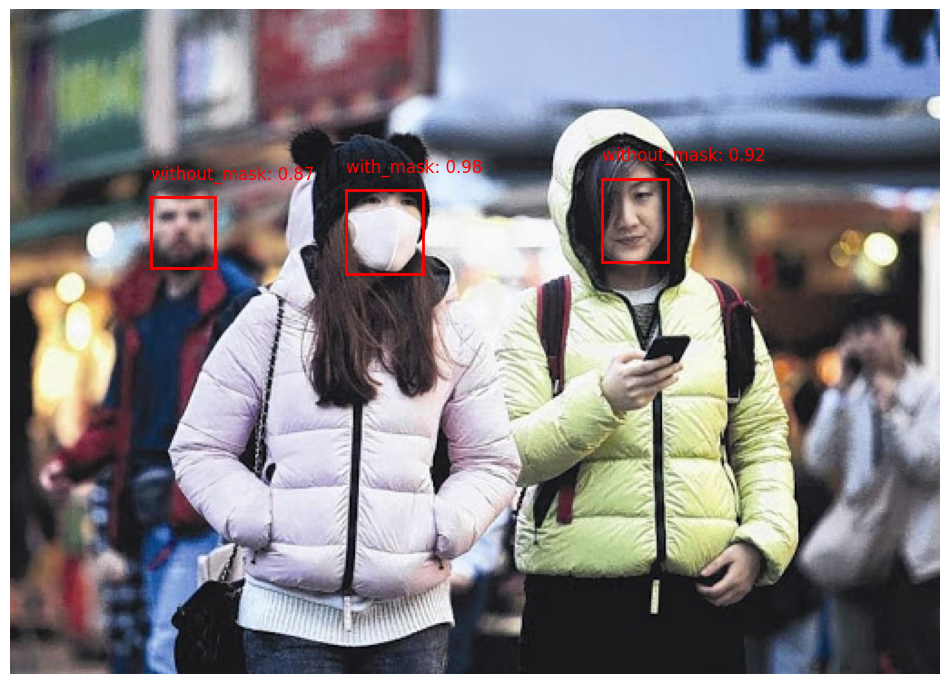

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as T
from PIL import Image
import torch

# Load your trained model
model.eval()

# Load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    return transform(image), image

# Perform inference
def predict(image_path, model, device, threshold=0.5):
    image_tensor, orig_image = load_image(image_path)
    image_tensor = image_tensor.to(device)

    model.eval()
    with torch.no_grad():
        prediction = model([image_tensor])[0]

    # Display results
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(orig_image)

    for box, label, score in zip(
        prediction['boxes'].cpu(), prediction['labels'].cpu(), prediction['scores'].cpu()
    ):
        if score >= threshold:
            xmin, ymin, xmax, ymax = box
            width, height = xmax - xmin, ymax - ymin
            rect = patches.Rectangle(
                (xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(
                xmin, ymin - 10,
                f"{id_to_label[label.item()]}: {score:.2f}",
                color='red', fontsize=12
            )

    plt.axis('off')
    plt.show()

# Label mapping
id_to_label = {0: "background", 1: "with_mask", 2: "without_mask"}

# Inference on an image
test_image_path = "/kaggle/input/face-mask-detection/images/maksssksksss0.png"
predict(test_image_path, model, device)
